<div style=" margin-bottom: 20px; ">
    <h1 style=" font-size: 24px; font-weight: bold; margin: 0; ">
        Hybrid Learning in Neural Networks for Almond Classification
    </h1>
</div>

<div style="max-width: 700px">
    <p style="line-height: 1.6; text-align: justify;">
        Armand Krynauw <br> <i>u04868286</i>
    </p>
</div>

<hr>
<hr>

<div style=" margin-bottom: 20px; ">
    <h1 style=" font-size: 24px; font-weight: bold; margin: 0; ">
        Neural Networks
    </h1>
</div>

<div style="max-width: 700px">
    <p style="line-height: 1.6; text-align: justify;">
        Below is a couple of simple feed-forward neural networks that will be used.
        PyTorch is used to implement the neural networks and Skorch is used to wrap the
        PyTorch models in a scikit-learn compatible API for easier training and
        evaluation.
    </p>
</div>

<hr>

In [1]:
import os
import sys
import random
import numpy as np

import torch
import torch.nn as nn

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

# ==================== PyTorch Models ====================

class SuperSimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SuperSimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim, activation_fn=torch.relu):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)

        self.batch_norm1 = nn.BatchNorm1d(256)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.batch_norm3 = nn.BatchNorm1d(64)

        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.batch_norm1(self.activation_fn(self.fc1(x)))
        x = self.batch_norm2(self.activation_fn(self.fc2(x)))
        x = self.batch_norm3(self.activation_fn(self.fc3(x)))
        x = self.fc4(x)
        return x

class ComplexNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.batch_norm3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.batch_norm1(torch.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.batch_norm2(torch.relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.batch_norm3(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

# ==================== Default Skorch Wrapper ====================

def generate_model(
    *,
    module=SimpleNN,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    max_epochs=200,
    batch_size=-1,
    verbose=False,
    lr=0.0001,
    train_split=None,
    device='cpu'
):
    model_callbacks = [
        EpochScoring("accuracy", on_train=True, name="train_acc", lower_is_better=False)
    ]

    model = NeuralNetClassifier(
        module=module,
        criterion=criterion,
        optimizer=optimizer,
        max_epochs=max_epochs,
        batch_size=batch_size,
        verbose=verbose,
        lr=lr,
        train_split=train_split,
        device=device,
        callbacks=model_callbacks
    )

    return model

# ==================== Misc Tasks ====================

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Ignore the specific FutureWarning from skorch.net
def disable_stderr():
    dev_null = open(os.devnull, 'w')
    old_stderr = sys.stderr
    sys.stderr = dev_null
    return old_stderr

def enable_stderr(old_stderr):
    sys.stderr = old_stderr

old_stderr = disable_stderr()

<div style=" margin-bottom: 20px; ">
    <h1 style=" font-size: 24px; font-weight: bold; margin: 0; ">
        Cross Validation and Grid Search
    </h1>
</div>

<div style="max-width: 700px">
    <p style="line-height: 1.6; text-align: justify;">
        Below are cross validation and grid search implementations that will be used to
        train and evaluate the neural networks.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        The cross validation employs stratified k-fold cross validation to ensure that
        the class distribution is preserved in each fold. Furthermore, the
        pre-processing pipeline is applied is fitted on the training data and then
        applied to the training and validation data in each fold to prevent data
        leakage.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        The grid search will be used for hyperparameter tuning.
    </p>
</div>

<hr>

In [2]:
import json

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import StandardScaler
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

class CrossValidate:
    def __init__(self, model, X, y, classes, preprocess_pipeline, n_splits=5, n_jobs=-1):
        self.model = model
        self.X = X
        self.y = y
        self.classes = classes
        self.preprocess_pipeline = preprocess_pipeline
        self.n_splits = n_splits
        self.n_jobs = n_jobs
        self.fold_stats = []

    def run(self):
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True)

        self.fold_stats = Parallel(n_jobs=self.n_jobs)(
            delayed(self.process_fold)(fold_num, train_index, valid_index)
            for fold_num, (train_index, valid_index) in enumerate(skf.split(self.X, self.y))
        )

    def process_fold(self, fold_num, train_index, valid_index):
        # print(f"Fold {fold_num+1} split started")
        X_train, X_valid = self.X.iloc[train_index], self.X.iloc[valid_index]
        y_train, y_valid = self.y.iloc[train_index], self.y.iloc[valid_index]

        X_train, X_valid = self.preprocess(X_train, X_valid)

        valid_dataset = Dataset(X_valid, y_valid)

        self.model.set_params(
            train_split=predefined_split(valid_dataset),
            module__input_dim=X_train.shape[1],
            module__output_dim=len(self.classes),
        )
        model_copy = self.model.initialize()

        model_copy.fit(X_train, y_train)
        return model_copy.history.to_list()

    def add_stats(self):
        self.fold_stats.append(self.model.history.to_list())

    def save_stats(self):
        with open("stats.json", "w") as f:
            json.dump(self.fold_stats, f)

    def important_stats(self):
        train_accuracies = []
        valid_accuracies = []
        train_losses = []
        valid_losses = []

        for fold in self.fold_stats:
            fold_train_accuracies = []
            fold_valid_accuracies = []
            fold_train_losses = []
            fold_valid_losses = []

            for epoch in fold:
                fold_train_accuracies.append(epoch["train_acc"])
                fold_valid_accuracies.append(epoch["valid_acc"])
                fold_train_losses.append(epoch["train_loss"])
                fold_valid_losses.append(epoch["valid_loss"])

            train_accuracies.append(fold_train_accuracies)
            valid_accuracies.append(fold_valid_accuracies)
            train_losses.append(fold_train_losses)
            valid_losses.append(fold_valid_losses)

        return {
            "train_accuracies": train_accuracies,
            "valid_accuracies": valid_accuracies,
            "train_losses": train_losses,
            "valid_losses": valid_losses,
        }

    def plot_important_stats(self):
        stats = self.important_stats()

        train_accuracies = stats["train_accuracies"]
        valid_accuracies = stats["valid_accuracies"]
        train_losses = stats["train_losses"]
        valid_losses = stats["valid_losses"]

        # Calculate mean and standard deviation
        mean_train_acc = np.mean(train_accuracies, axis=0)
        mean_valid_acc = np.mean(valid_accuracies, axis=0)
        std_train_acc = np.std(train_accuracies, axis=0)
        std_valid_acc = np.std(valid_accuracies, axis=0)

        mean_train_loss = np.mean(train_losses, axis=0)
        mean_valid_loss = np.mean(valid_losses, axis=0)
        std_train_loss = np.std(train_losses, axis=0)
        std_valid_loss = np.std(valid_losses, axis=0)

        # Gruvbox colors
        gruvbox_light_colors = ["#fbf1c7", "#ebdbb2", "#d5c4a1", "#bdae93", "#665c54", "#504945", "#3c3836", "#282828"]

        # Figure and axes
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot accuracies
        ax1.plot(mean_train_acc, label="Train Accuracy", color="#d65d0e")  # Gruvbox orange
        ax1.plot(mean_valid_acc, label="Validation Accuracy", color="#458588")  # Gruvbox blue
        ax1.fill_between(
            range(len(mean_train_acc)),
            mean_train_acc - std_train_acc,
            mean_train_acc + std_train_acc,
            alpha=0.2,
            color="#d65d0e"
        )
        ax1.fill_between(
            range(len(mean_valid_acc)),
            mean_valid_acc - std_valid_acc,
            mean_valid_acc + std_valid_acc,
            alpha=0.2,
            color="#458588"
        )
        ax1.set_xlabel("Epoch", fontweight='bold')
        ax1.set_ylabel("Accuracy", fontweight='bold')
        ax1.legend()
        ax1.set_title("Accuracy over Epochs", fontweight='bold')

        # Plot losses
        ax2.plot(mean_train_loss, label="Train Loss", color="#d65d0e")  # Gruvbox orange
        ax2.plot(mean_valid_loss, label="Validation Loss", color="#458588")  # Gruvbox blue
        ax2.fill_between(
            range(len(mean_train_loss)),
            mean_train_loss - std_train_loss,
            mean_train_loss + std_train_loss,
            alpha=0.2,
            color="#d65d0e"
        )
        ax2.fill_between(
            range(len(mean_valid_loss)),
            mean_valid_loss - std_valid_loss,
            mean_valid_loss + std_valid_loss,
            alpha=0.2,
            color="#458588"
        )
        ax2.set_xlabel("Epoch", fontweight='bold')
        ax2.set_ylabel("Loss", fontweight='bold')
        ax2.legend()
        ax2.set_title("Loss over Epochs", fontweight='bold')

        # Background color
        fig.patch.set_facecolor(gruvbox_light_colors[0])
        ax1.set_facecolor(gruvbox_light_colors[1])
        ax2.set_facecolor(gruvbox_light_colors[1])

        # Layout and display
        plt.tight_layout()
        plt.show()

    def print_summary_stats(self):
        stats = self.important_stats()

        last_train_accuracies = [split[-1] for split in stats["train_accuracies"]]
        last_valid_accuracies = [split[-1] for split in stats["valid_accuracies"]]
        last_train_losses = [split[-1] for split in stats["train_losses"]]
        last_valid_losses = [split[-1] for split in stats["valid_losses"]]

        metrics = {
            "Last Train Accuracy": (np.mean(last_train_accuracies), np.std(last_train_accuracies)),
            "Last Valid Accuracy": (np.mean(last_valid_accuracies), np.std(last_valid_accuracies)),
            "Last Train Loss": (np.mean(last_train_losses), np.std(last_train_losses)),
            "Last Valid Loss": (np.mean(last_valid_losses), np.std(last_valid_losses))
        }

        for metric, (mean, std) in metrics.items():
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

    def preprocess(self, X_train, X_test):
        """
        Fit the transformations on the training data.
        Apply the transformations on the training and testing data.
        """
        X_train_processed = self.preprocess_pipeline.fit_transform(X_train)
        X_test_processed = self.preprocess_pipeline.transform(X_test)
        return X_train_processed, X_test_processed

class GridSearch:
    def __init__(self, model, param_grid, X, y, classes, preprocess_pipeline, n_splits=5, n_jobs=-1):
        self.model = model
        self.param_grid = param_grid
        self.X = X
        self.y = y
        self.classes = classes
        self.preprocess_pipeline = preprocess_pipeline
        self.n_splits = n_splits
        self.n_jobs = n_jobs
        self.results = []

    def run(self):
        param_combinations = list(product(*[param['values'] for param in self.param_grid.values()]))

        for params in param_combinations:
            param_dict = {}
            for (key, param_info), value in zip(self.param_grid.items(), params):
                if isinstance(value, tuple):
                    param_dict[key] = value[1]
                else:
                    param_dict[key] = value

            # Initialize model with new params and run cross validation
            self.model.set_params(**param_dict)
            cv = CrossValidate(self.model, self.X, self.y, self.classes, self.preprocess_pipeline, self.n_splits, self.n_jobs)
            cv.run()

            # Use the mean of the validation accuracies of final epochs as the score
            mean_accuracy = np.mean([fold[-1]['valid_acc'] for fold in cv.fold_stats if fold])
            self.results.append((*params, mean_accuracy))

        print("Best parameters:", self.get_best_params())

    def get_best_params(self):
        best_result = max(self.results, key=lambda x: x[-1])
        return dict(zip(self.param_grid.keys(), [p[1] if isinstance(p, tuple) else p for p in best_result[:-1]]))

    def plot_heatmap(self):
        if len(self.param_grid) != 2:
            raise ValueError("Heatmap requires exactly 2 params")

        param_names = list(self.param_grid.keys())
        df = pd.DataFrame(self.results, columns=[*param_names, 'accuracy'])

        for param in param_names:
            if isinstance(df[param].iloc[0], tuple):
                df[param] = df[param].apply(lambda x: x[0])

        pivot = df.pivot(index=param_names[0], columns=param_names[1], values='accuracy')

        # Gruvbox light colors
        gruvbox_colors = ["#282828", "#3c3836", "#504945", "#665c54", "#bdae93", "#d5c4a1", "#ebdbb2", "#fbf1c7"]
        gruvbox_cmap = LinearSegmentedColormap.from_list("gruvbox", gruvbox_colors)

        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot, annot=True, cmap=gruvbox_cmap, center=pivot.mean().mean())
        plt.title('Grid Search Results', fontweight='bold')
        plt.xlabel(self.param_grid[param_names[1]].get('label', param_names[1]), fontweight='bold')
        plt.ylabel(self.param_grid[param_names[0]].get('label', param_names[0]), fontweight='bold')
        plt.show()

<div style=" margin-bottom: 20px; ">
    <h1 style=" font-size: 24px; font-weight: bold; margin: 0; ">
        Data Pre-processing
    </h1>
</div>

<div style="max-width: 700px">
    <p style="line-height: 1.6; text-align: justify;">
        Simple mean imputation is used to fill missing values in the data. The data is
        then scaled using the standard scaler for consumption by the neural networks.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        Mean imputation was used as it is simple and effective. More advanced techniques like feature
        engineering and KNN imputation could have been attempted to improve the imputation process. We could
        have also attempted to reduce the dimensions of length, width, and height down to two dimensions in
        order to discard missing values. Then one-hot encoding could have been used to encode which dimensions
        were kept. However, non of these complexities deemed worth the effort since the models performed well
        with simple mean imputation.
    </p>
</div>

<hr>

In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

def read_and_split_data(test_size: float = 0.0):
    df = pd.read_csv("Almond.csv")

    # Remove features that has > 60% missing values
    df_cleaned = df.drop(columns=["Unnamed: 0", "Aspect Ratio", "Eccentricity"])

    # Encode the target variable
    label_encoder = LabelEncoder()
    df_cleaned["Type"] = label_encoder.fit_transform(df_cleaned["Type"])
    classes = label_encoder.classes_

    # Split dataset
    X = df_cleaned.drop(columns=["Type"])
    y = df_cleaned["Type"]

    if test_size == 0:
        return X, y, classes
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        return X_train, X_test, y_train, y_test, classes

def preprocess_pipeline() -> Pipeline:
    return Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ( "float32", FunctionTransformer(func=lambda X: torch.tensor(X, dtype=torch.float32), validate=False)),
    ])


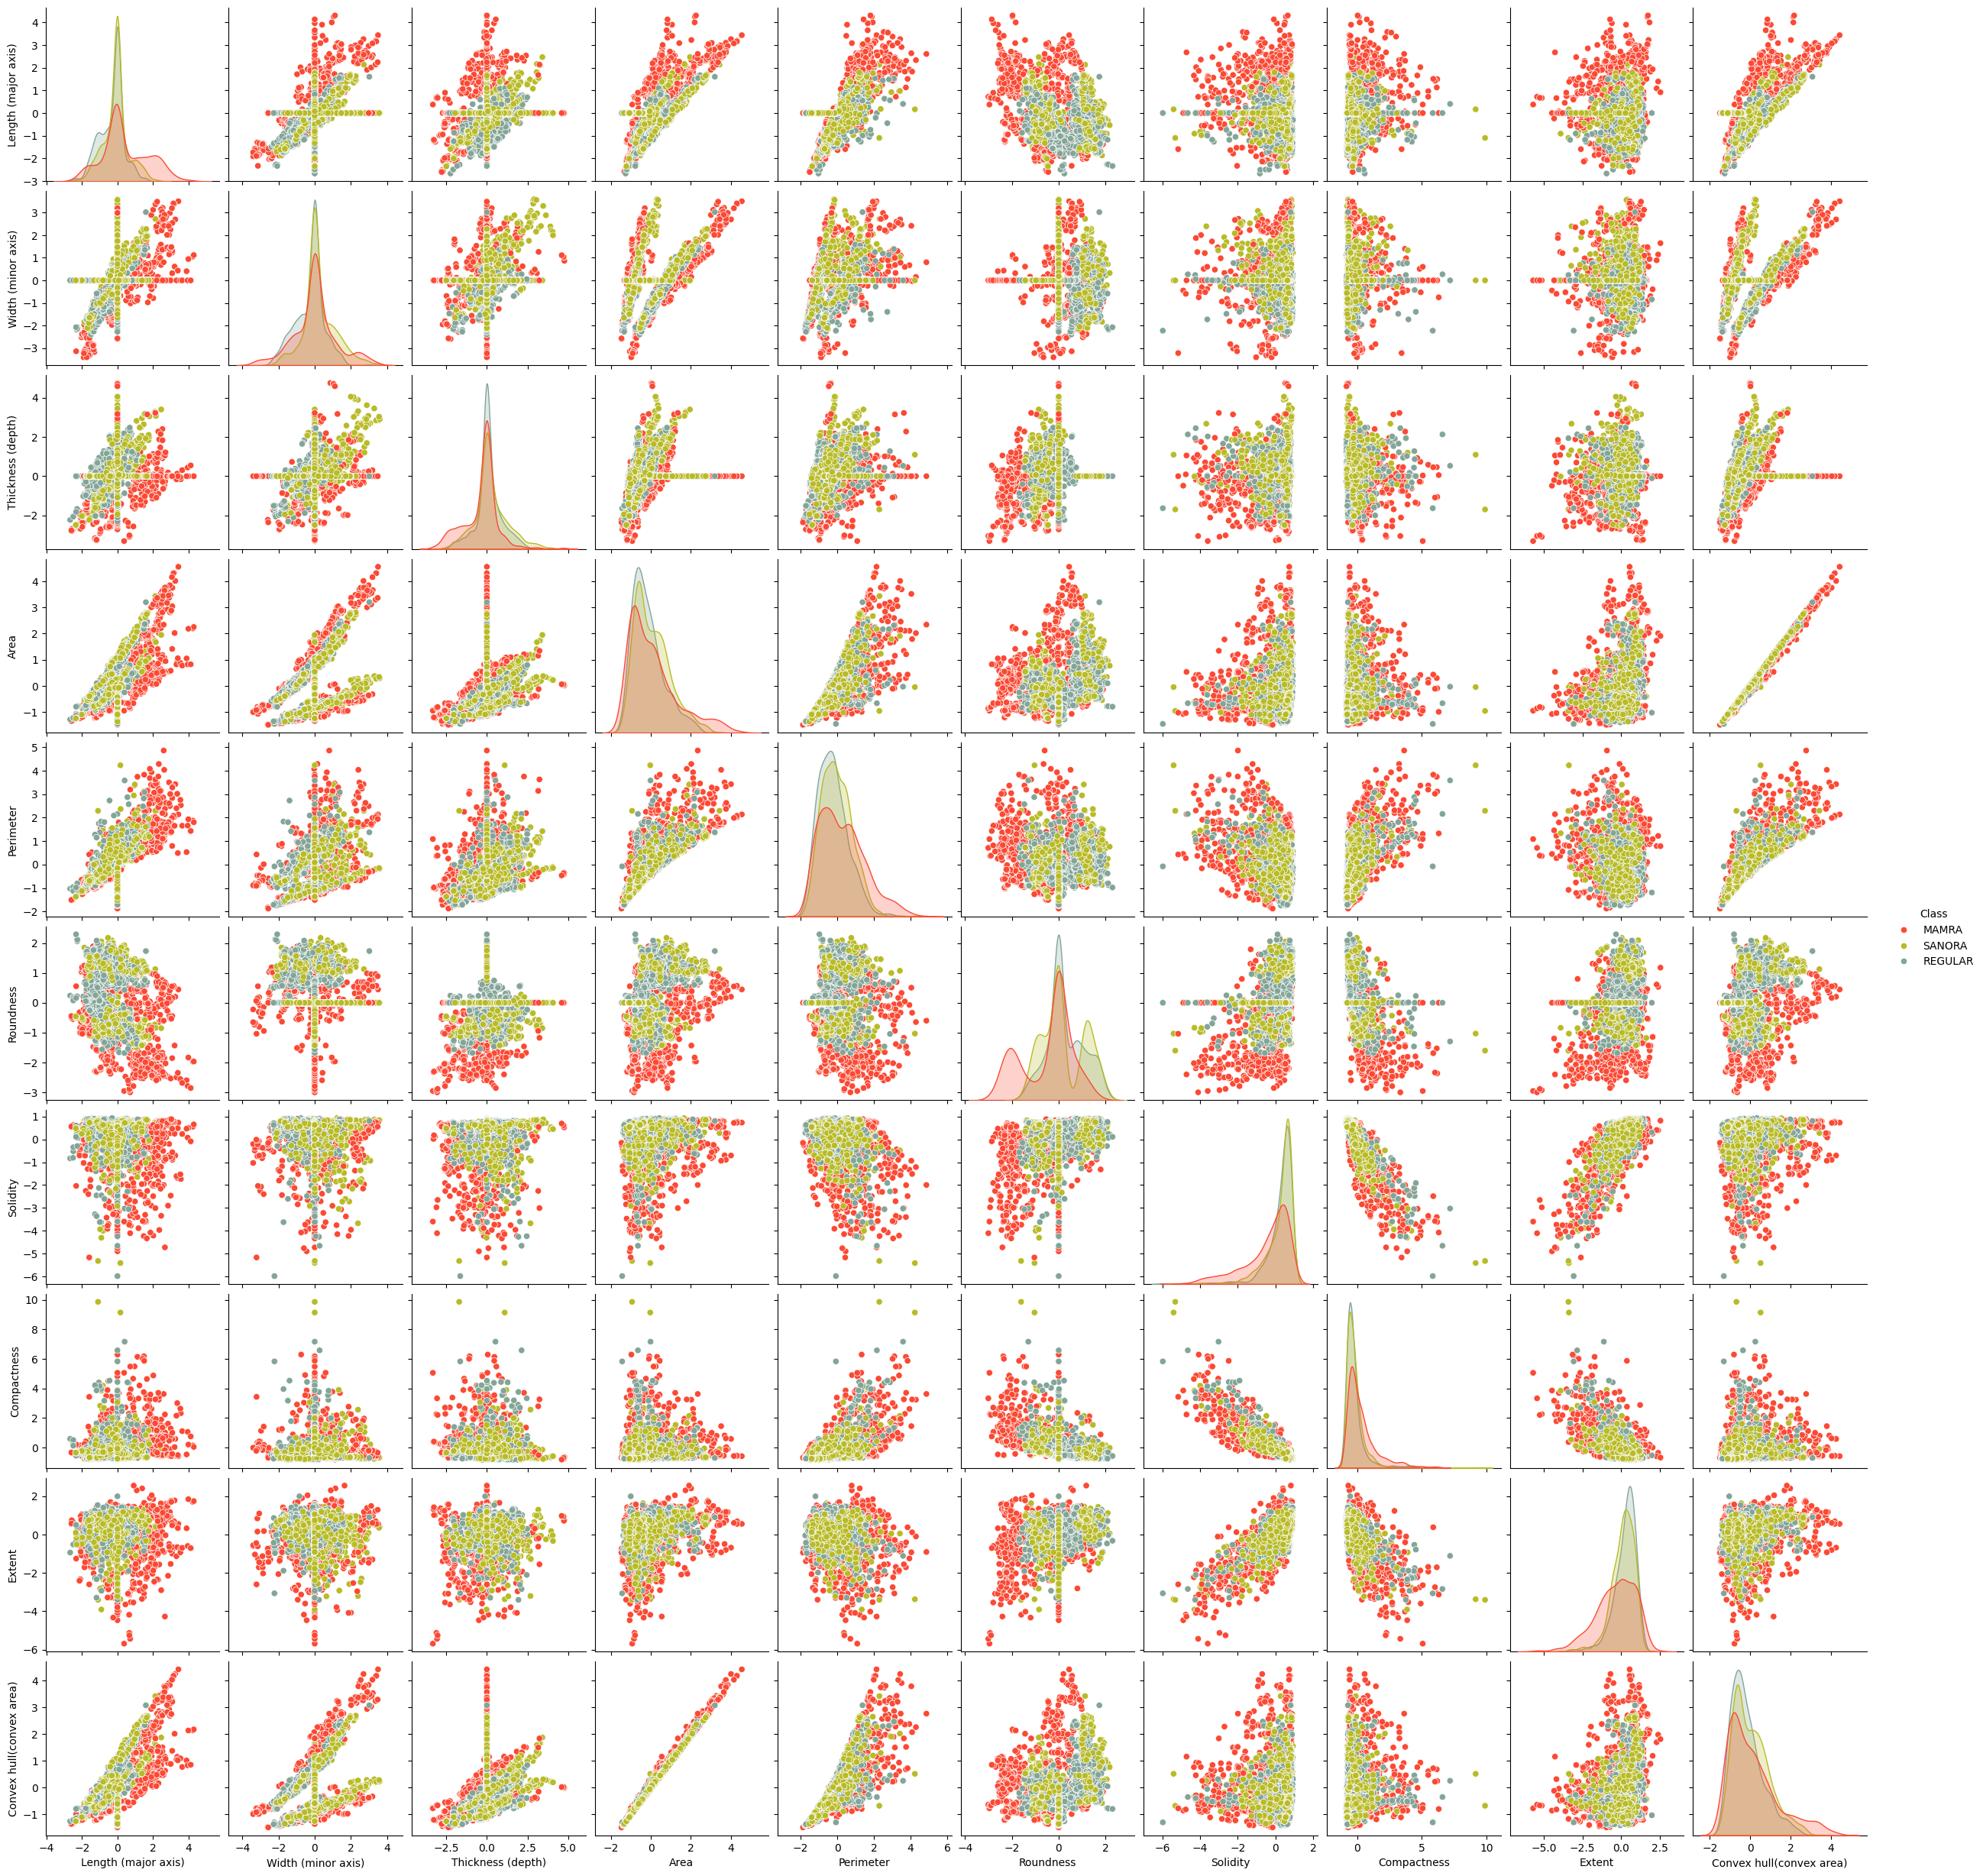

In [6]:
X, y, classes = read_and_split_data()
pipeline = preprocess_pipeline()
X_transformed = pipeline.fit_transform(X)

# Combine features and target variable
df_combined = pd.DataFrame(X_transformed, columns=X.columns)
df_combined['Type'] = y

# Map classes
class_map = {i: name for i, name in enumerate(classes)}
df_combined['Type'] = df_combined['Type'].map(class_map)

# Style
gruvbox_palette = ['#fb4934', '#b8bb26', '#83a598']  # Red, Green, Blue from Gruvbox
sns.set_palette(gruvbox_palette)

# Plot
g = sns.pairplot(df_combined, hue="Type")
g._legend.set_title("Class")
plt.show()

<div style=" margin-bottom: 20px; ">
    <h1 style=" font-size: 24px; font-weight: bold; margin: 0; ">
        Baseline Model
    </h1>
</div>

<div style="max-width: 700px">
    <p style="line-height: 1.6; text-align: justify;">
        Training a simple feed-forward neural network with a single hidden layer with ReLu activation.
        We use the Adam optimizer and the binary cross entropy loss function. Full batches are used as well.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        We note that the initial model is a solid starting point with an accuracy of 0.85. However, we can
        see some over-fitting is present on the loss curve by the validation loss plateauing before the training
        loss.
    </p>
</div>

<hr>

Last Train Accuracy: 0.9890 ± 0.0031
Last Valid Accuracy: 0.8570 ± 0.0157
Last Train Loss: 0.0940 ± 0.0139
Last Valid Loss: 0.4122 ± 0.0558


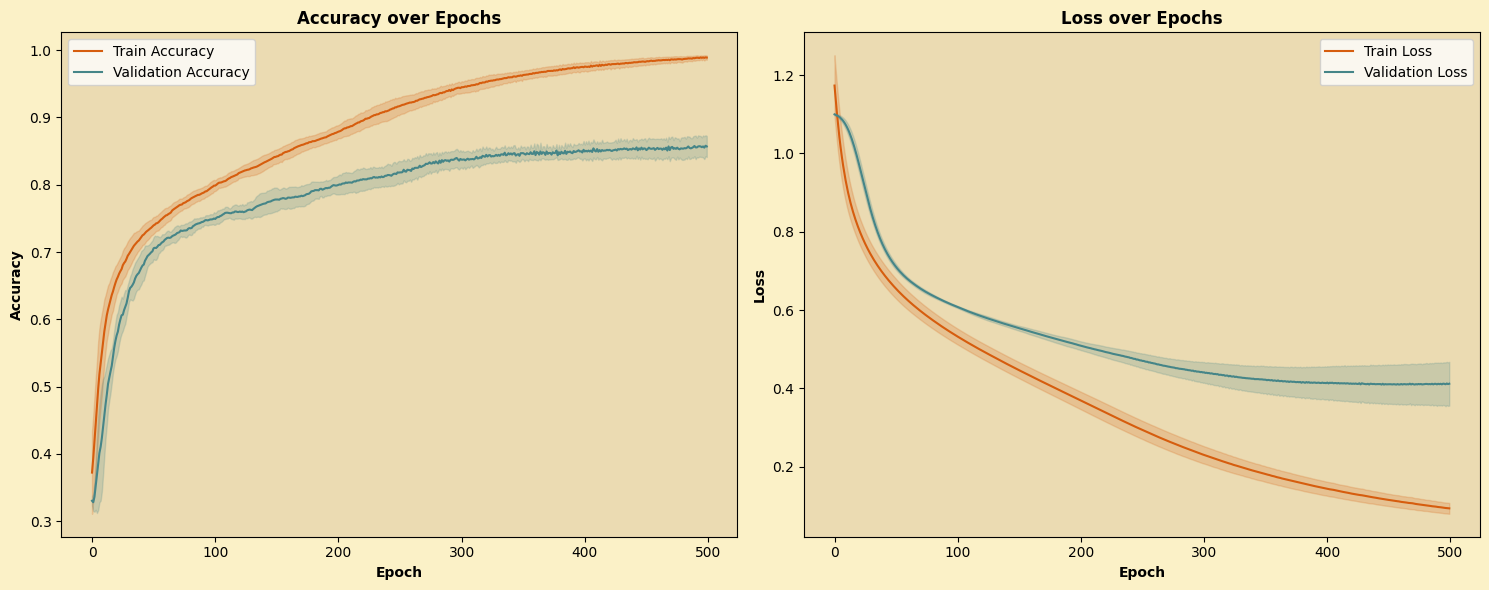

In [29]:
model = generate_model(module=SimpleNN, lr=0.0001, max_epochs=500)
X, y, classes = read_and_split_data()

cv = CrossValidate(model, X, y, classes, preprocess_pipeline(), n_splits=5)

cv.run()
cv.print_summary_stats()
cv.plot_important_stats()

<div style=" margin-bottom: 20px; ">
    <h1 style=" font-size: 24px; font-weight: bold; margin: 0; ">
        Basic Grid Search
    </h1>
</div>

<div style="max-width: 700px">
    <p style="line-height: 1.6; text-align: justify;">
        Training a simple feed-forward neural network with a single hidden layer with ReLu activation.
        We use the Adam optimizer and the binary cross entropy loss function.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        From the grid search, we can see that in the case of the Adam optimizer, that a lower learning rate
        with a higher number of epochs is better in most cases.
    </p>
</div>

<hr>

Best parameters: {'optimizer__lr': 0.01, 'max_epochs': 500}


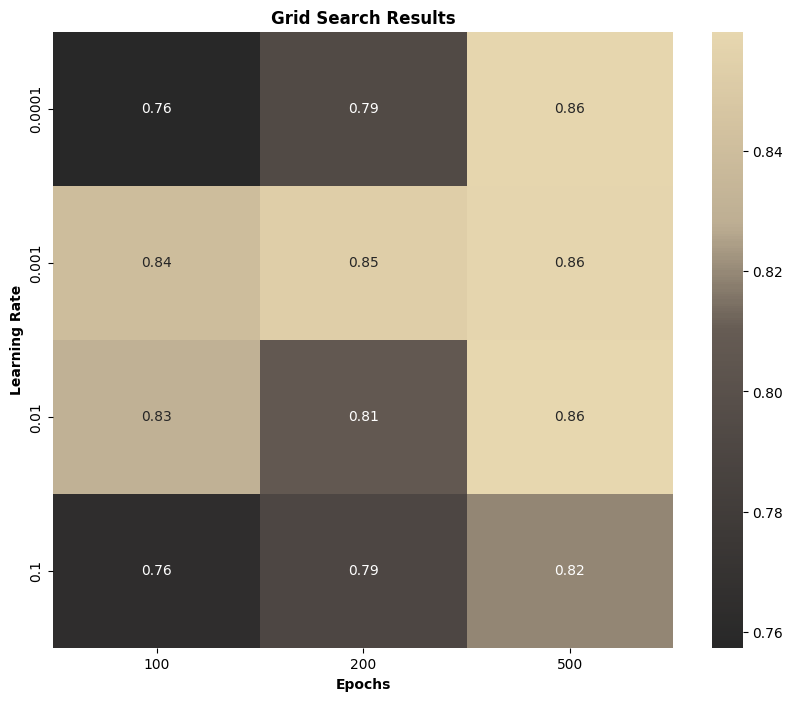

In [11]:
# Hyperparameters to search
params = {
    'optimizer__lr': {
        'label': 'Learning Rate',
        'values': [0.1, 0.01, 0.001, 0.0001]
    },
    'max_epochs': {
        'label': 'Epochs',
        'values': [100, 200, 500]
    }
}

model = generate_model(module=SimpleNN)
X, y, classes = read_and_split_data()

gs = GridSearch(model, params, X, y, classes, preprocess_pipeline(), n_splits=5)
gs.run()
gs.plot_heatmap()

Best parameters: {'optimizer__lr': 0.01, 'module__activation_fn': <built-in method relu of type object at 0x11cdf8cf0>}


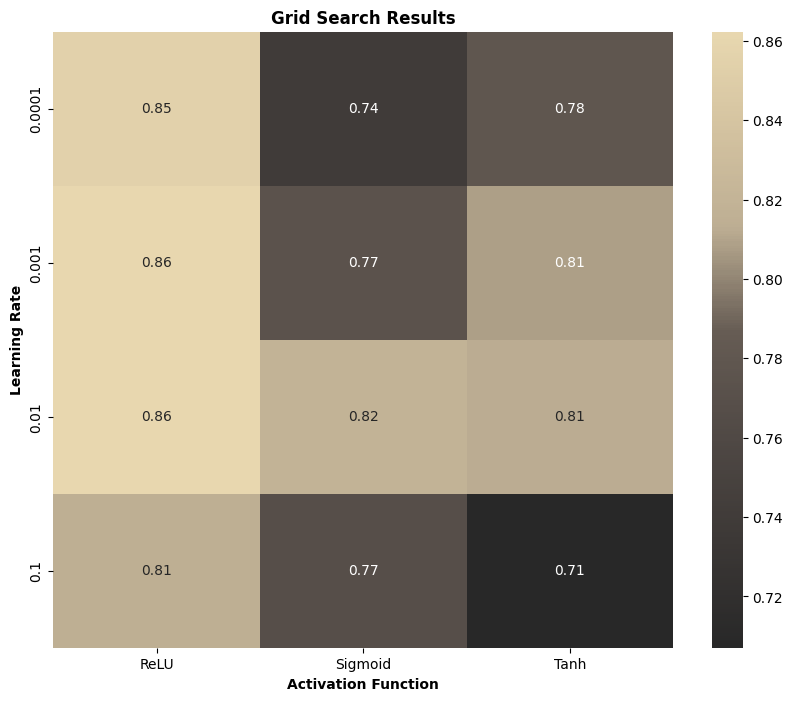

In [12]:
# Hyperparameters to search
params = {
    'optimizer__lr': {
        'label': 'Learning Rate',
        'values': [0.1, 0.01, 0.001, 0.0001]
    },
    'module__activation_fn': {
        'label': 'Activation Function',
        'values': [("ReLU", torch.relu), ("Sigmoid", torch.sigmoid), ("Tanh", torch.tanh)]
    },
}

model = generate_model(module=SimpleNN, max_epochs=500)
X, y, classes = read_and_split_data()

gs = GridSearch(model, params, X, y, classes, preprocess_pipeline(), n_splits=5)
gs.run()
gs.plot_heatmap()

<div style=" margin-bottom: 20px; ">
    <h1 style=" font-size: 24px; font-weight: bold; margin: 0; ">
        Exploring Different Optimizers
    </h1>
</div>

<div style="max-width: 700px">
    <p style="line-height: 1.6; text-align: justify;">
        The stochastic gradient descent (SGD) optimizer appears to be quite stable during training and quite slow to converge.
        If we let it train for more epochs, it may eventually reach the same accuracy as the Adam optimizer, but we can already
        see the validation loss starting to plateau.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        The Adam optimizer converges much faster than the SGD optimizer and reaches a higher accuracy.
        However, there is quite a bit of over-fitting present as the validation loss starts to plateau before the training loss.
        We can also see a huge amount of unstable behavior in the loss curves around the middle of the training process.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        RMSprop converges the fastest, but also over-fits the most. A way lower learning rate and
        reducing the training epochs might help with the over-fitting.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        Dropout regularization can also help with over-fitting that is present in the Adam and RMSprop optimizers.
    </p>
</div>

<hr>

Stochastic Gradient Descent Optimizer
Last Train Accuracy: 0.8296 ± 0.0048
Last Valid Accuracy: 0.7717 ± 0.0111
Last Train Loss: 0.4173 ± 0.0109
Last Valid Loss: 0.5415 ± 0.0285


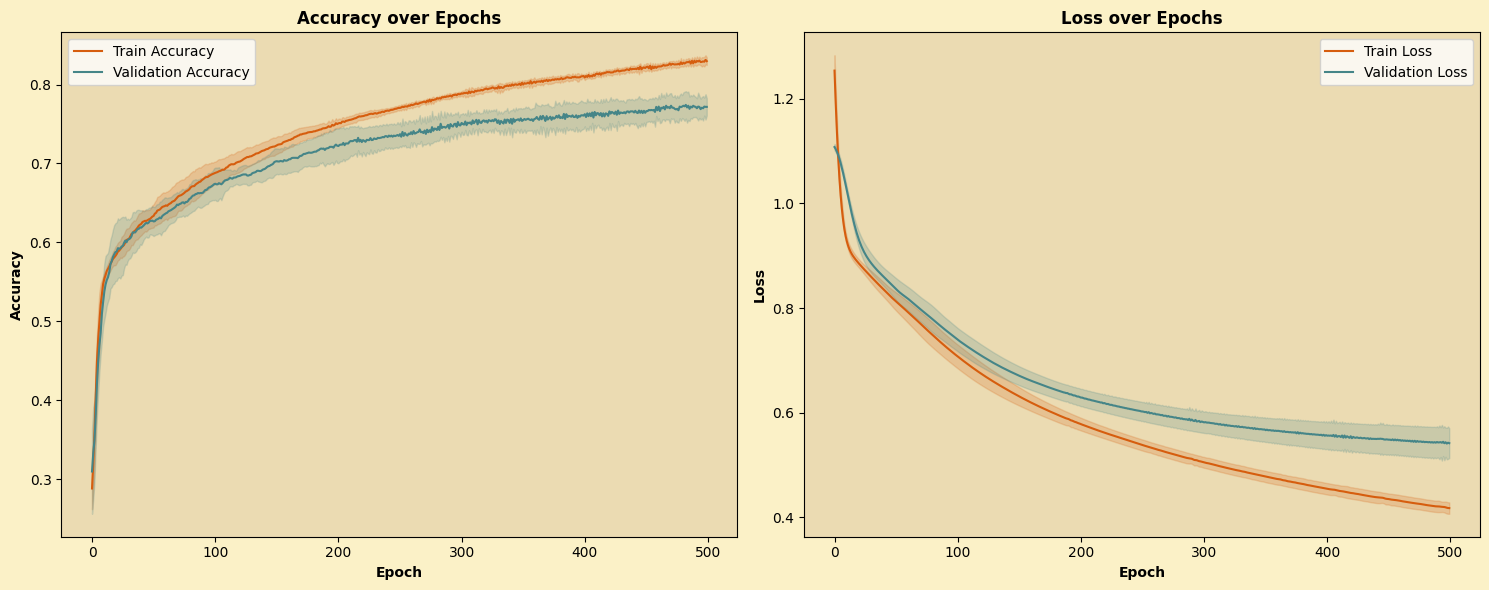

Adam Optimizer
Last Train Accuracy: 1.0000 ± 0.0000
Last Valid Accuracy: 0.8523 ± 0.0167
Last Train Loss: 0.0023 ± 0.0009
Last Valid Loss: 0.7476 ± 0.1188


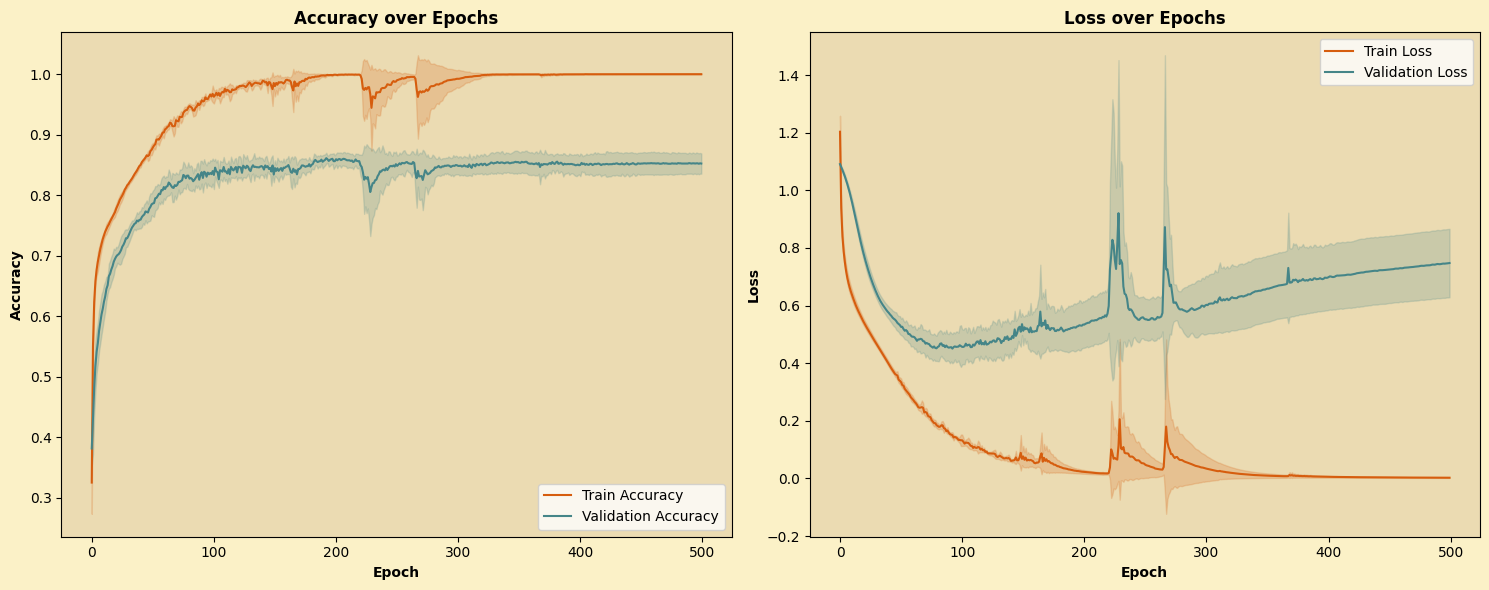

RProp Optimizer
Last Train Accuracy: 1.0000 ± 0.0000
Last Valid Accuracy: 0.8377 ± 0.0160
Last Train Loss: 0.0000 ± 0.0000
Last Valid Loss: 6.7219 ± 0.9277


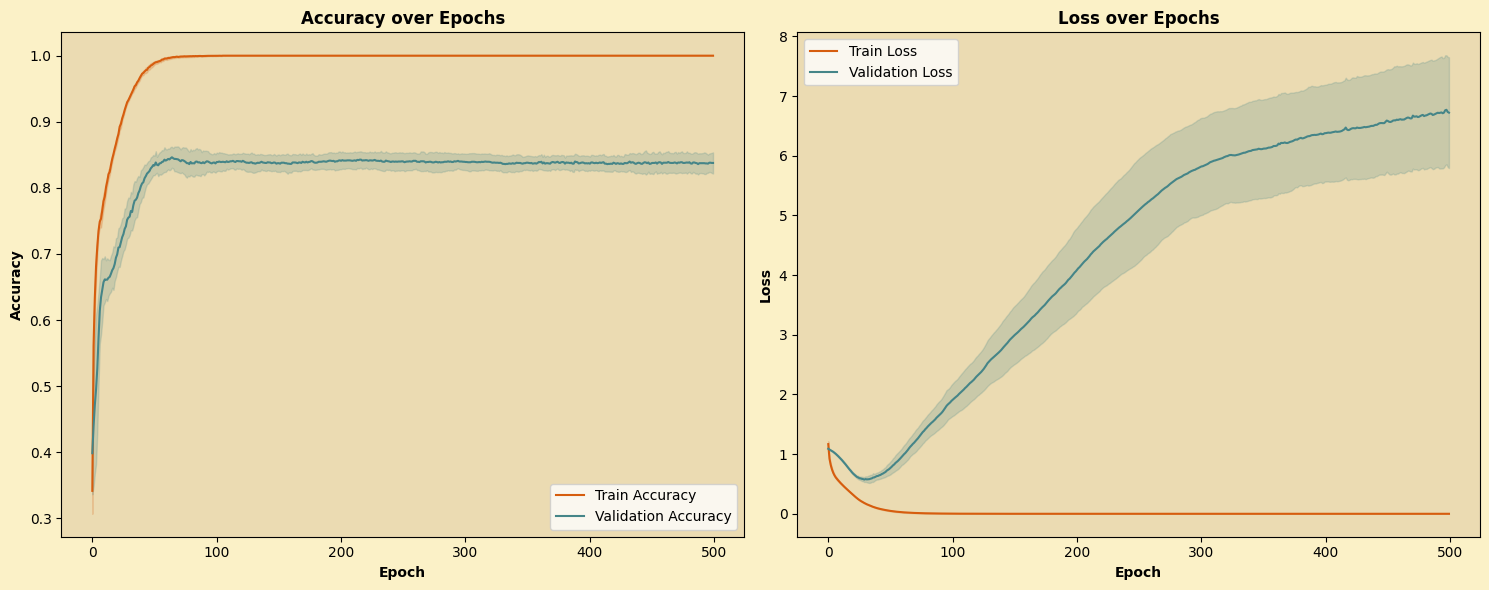

In [9]:
X, y, classes = read_and_split_data()

print("Stochastic Gradient Descent Optimizer")
model_sgd = generate_model(module=SimpleNN, lr=0.001, max_epochs=500, optimizer=torch.optim.SGD)
cv_sgd = CrossValidate(model, X, y, classes, preprocess_pipeline(), n_splits=5)

cv_sgd.run()
cv_sgd.print_summary_stats()
cv_sgd.plot_important_stats()

print("Adam Optimizer")
model_adam = generate_model(module=SimpleNN, lr=0.001, max_epochs=500, optimizer=torch.optim.Adam)
cv_adam = CrossValidate(model_adam, X, y, classes, preprocess_pipeline(), n_splits=5)

cv_adam.run()
cv_adam.print_summary_stats()
cv_adam.plot_important_stats()

print("RProp Optimizer")
model_rprop = generate_model(module=SimpleNN, lr=0.001, max_epochs=500, optimizer=torch.optim.Rprop)
cv_rprop = CrossValidate(model_rprop, X, y, classes, preprocess_pipeline(), n_splits=5)

cv_rprop.run()
cv_rprop.print_summary_stats()
cv_rprop.plot_important_stats()

<div style=" margin-bottom: 20px; ">
    <h1 style=" font-size: 24px; font-weight: bold; margin: 0; ">
        Different Optimizers with Dropout Regularization
    </h1>
</div>

<div style="max-width: 700px">
    <p style="line-height: 1.6; text-align: justify;">
        We make use of dropout regularization to help with the over-fitting
        that is present in the Adam and RMSprop optimizers. Dropout rate of 0.3 is
        use for each hidden layer.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        We can see some interesting results. The SGD optimizer is still quite slow to converge,
        and the curves look basically the exact same as before. There was no change in the
        accuracy either.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        The Adam optimizer has stabilized a lot more and the validation loss is no longer shows
        signs of extreme over-fitting. The final accuracy has increased to 0.85.
    </p>
    <p style="line-height: 1.6; text-align: justify;">
        The RMSprop optimizer has also stabilized a lot more and the validation loss is no longer shows
        signs of extreme over-fitting. However, the model converges extremely fast and and plateaus
        almost immediately at an accuracy a little lower than earlier at 0.76
    </p>
</div>

<hr>

Stochastic Gradient Descent Optimizer
Last Train Accuracy: 0.8330 ± 0.0143
Last Valid Accuracy: 0.7738 ± 0.0161
Last Train Loss: 0.4112 ± 0.0213
Last Valid Loss: 0.5246 ± 0.0343


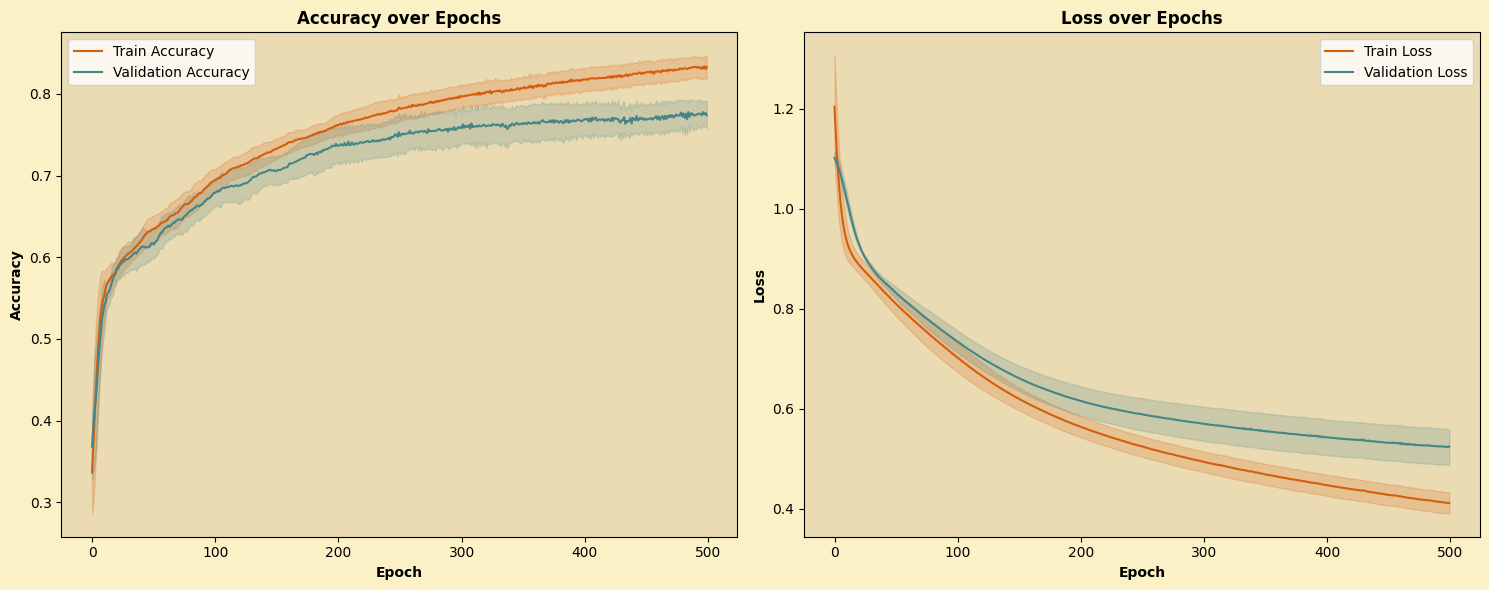

Adam Optimizer
Last Train Accuracy: 0.8882 ± 0.0039
Last Valid Accuracy: 0.8430 ± 0.0071
Last Train Loss: 0.2611 ± 0.0084
Last Valid Loss: 0.4342 ± 0.0277


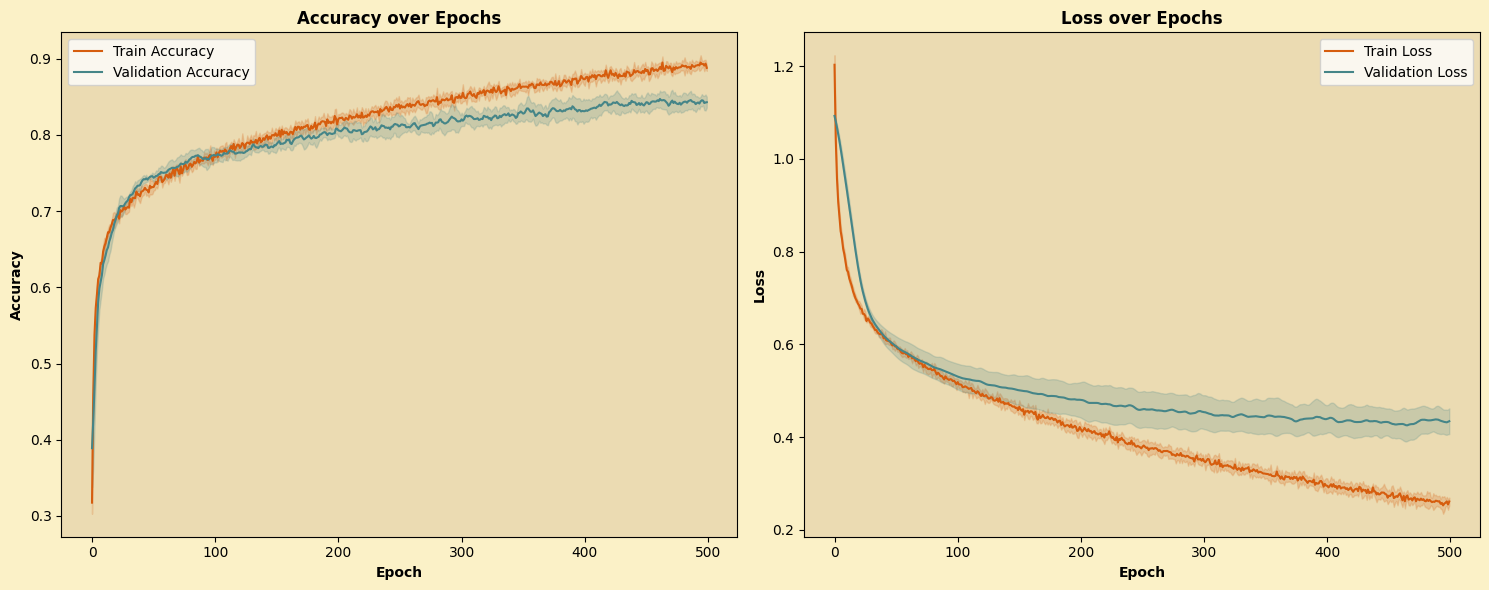

RProp Optimizer
Last Train Accuracy: 0.7580 ± 0.0090
Last Valid Accuracy: 0.7645 ± 0.0090
Last Train Loss: 0.5407 ± 0.0054
Last Valid Loss: 0.5393 ± 0.0139


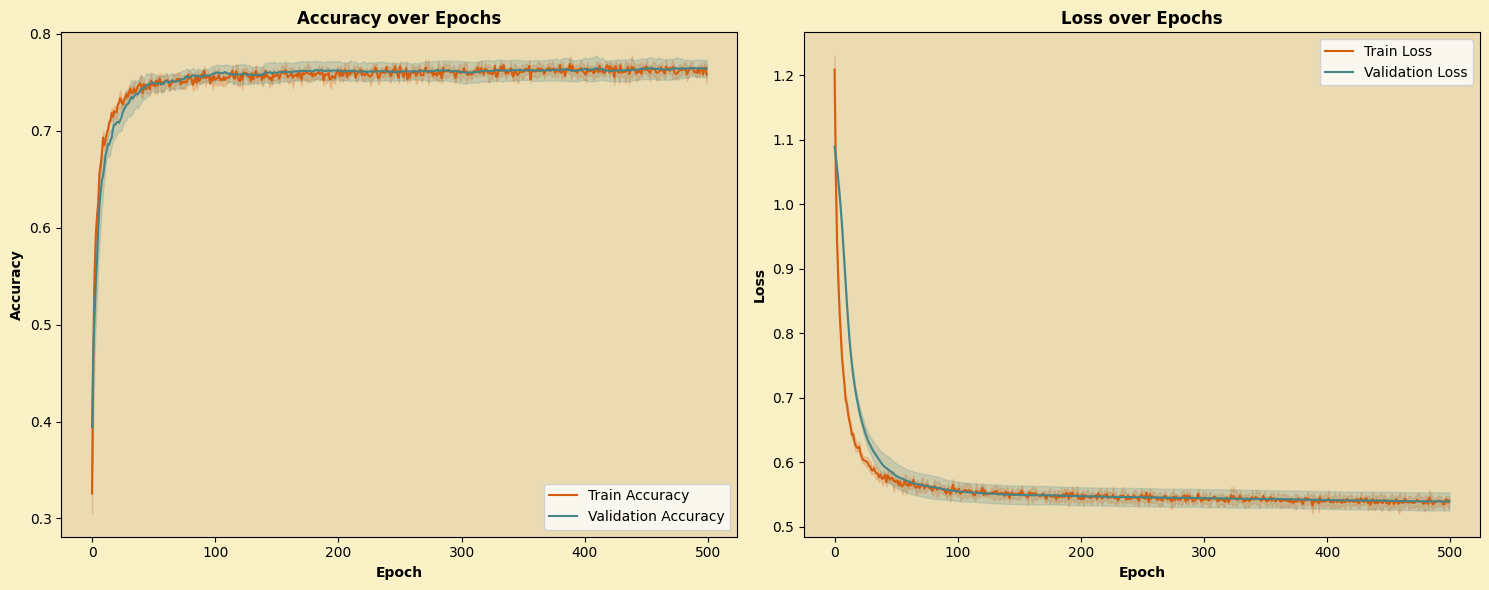

In [10]:
X, y, classes = read_and_split_data()

print("Stochastic Gradient Descent Optimizer")
model_sgd = generate_model(module=ComplexNN, lr=0.001, max_epochs=500, optimizer=torch.optim.SGD)
cv_sgd = CrossValidate(model, X, y, classes, preprocess_pipeline(), n_splits=5)

cv_sgd.run()
cv_sgd.print_summary_stats()
cv_sgd.plot_important_stats()

print("Adam Optimizer")
model_adam = generate_model(module=ComplexNN, lr=0.001, max_epochs=500, optimizer=torch.optim.Adam)
cv_adam = CrossValidate(model_adam, X, y, classes, preprocess_pipeline(), n_splits=5)

cv_adam.run()
cv_adam.print_summary_stats()
cv_adam.plot_important_stats()

print("RProp Optimizer")
model_rprop = generate_model(module=ComplexNN, lr=0.001, max_epochs=500, optimizer=torch.optim.Rprop)
cv_rprop = CrossValidate(model_rprop, X, y, classes, preprocess_pipeline(), n_splits=5)

cv_rprop.run()
cv_rprop.print_summary_stats()
cv_rprop.plot_important_stats()

Best parameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.001}


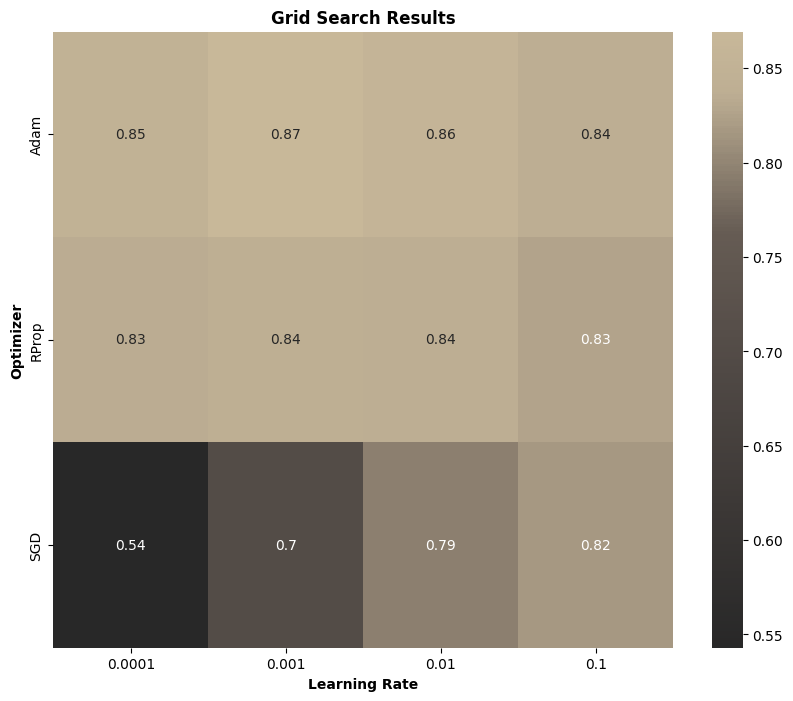

In [5]:
# Hyperparameters to search
params = {
    'optimizer': {
        'label': 'Optimizer',
        'values': [("SGD", torch.optim.SGD), ("Adam", torch.optim.Adam), ("RProp", torch.optim.Rprop)]
    },
    'optimizer__lr': {
        'label': 'Learning Rate',
        'values': [0.1, 0.01, 0.001, 0.0001]
    },
}

model = generate_model(module=SimpleNN, max_epochs=500)
X, y, classes = read_and_split_data()

gs = GridSearch(model, params, X, y, classes, preprocess_pipeline(), n_splits=5)
gs.run()
gs.plot_heatmap()

<div style=" margin-bottom: 20px; ">
    <h1 style=" font-size: 24px; font-weight: bold; margin: 0; ">
        Training with Hybrid Optimizers
    </h1>
</div>

<div style="max-width: 700px">
    <p style="line-height: 1.6; text-align: justify;">
        Due to technical difficulties and skill issues the hybrid learning optimizer was not fully implemented,
        and has thus been left out. ඞ
    </p>
</div>

<hr>